In [1]:
from collections import defaultdict
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq.xls")
runs = ["20220719_K562R1", "20220719_K562R2", "20220719_K562R3", "20220719_K562R4", "20220729_K562R1", "20220729_K562R2"]

# Distribution of edit distance

In [2]:
data = dict()
for run in runs:
    path = "../../1_NanoNASCseq/results/demux/fbilr/%s.stats.tsv.gz" % run
    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    d.columns = ["Barcode1", "Direction1", "Location1", "ED1", "Barcode2", "Direction2", "Location2", "ED2", "Count"]
    counter = defaultdict(int)
    for ed1, ed2, count in d[["ED1", "ED2", "Count"]].values:
        if ed1 != -1:
            counter[ed1] += count
            counter[ed2] += count
    data[run] = counter

ED	Mean	Std
0	66.75829314680554	3.090874977069541
1	7.850915001988454	0.8323546922086369
2	5.029946969061022	0.5181100042423425
3	3.589470843204348	0.39879306301686823
4	2.5890907825519744	0.26593649176924633
5	2.1300222408751317	0.1614376410742752
6	4.355916541086157	0.784277964811518
≥7	7.696344474427366	0.9274916400272356


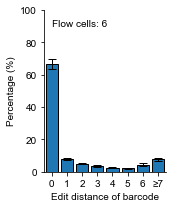

In [3]:
max_ed = 7
rows = []
for run in runs:
    counter = data[run]
    row = [counter[x] for x in range(0, max_ed)]
    row.append(sum(counter.values()) - sum(row))
    rows.append(row)
d = pd.DataFrame(rows)
d.index = runs
d = d.divide(d.sum(axis=1), axis=0) * 100

ys = d.mean(axis=0)
yerr = d.std(axis=0)
xs = np.arange(len(ys))
ticks = [str(x) for x in xs]
ticks[-1] = "≥%s" % ticks[-1]
print("ED\tMean\tStd")
for s, y, ye in zip(ticks, ys, yerr):
    print(s, y, ye, sep="\t")

plt.figure(figsize=(2.5, 3))
plt.bar(xs, ys, yerr=yerr, lw=1, capsize=4, width=0.8, color="C0", edgecolor="black", error_kw={"lw": 1})
plt.text(0, 90, "Flow cells: %d" % len(runs))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.xticks(xs, ticks)
plt.xlabel("Edit distance of barcode")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/barcode_ed_distribution.pdf", dpi=300)

# Pattern of barcode direction and location

In [7]:
data = dict()
for run in runs:
    path = "../../1_NanoNASCseq/results/demux/fbilr/%s.stats.tsv.gz" % run
    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    d.columns = ["Barcode1", "Direction1", "Location1", "ED1", "Barcode2", "Direction2", "Location2", "ED2", "Count"]
    d = d[["Direction1", "Location1", "ED1", "Direction2", "Location2", "ED2", "Count"]]
    counter = defaultdict(int)
    for direct1, loc1, ed1, direct2, loc2, ed2, count in d.values:
        if ed1 != -1:
            counter[(ed1, direct1, loc1)] += count
            counter[(ed2, direct2, loc2)] += count
    data[run] = counter

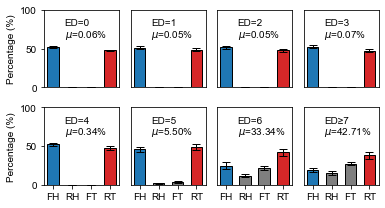

In [8]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(5.5, 3))
for ed in np.arange(ncol * nrow):
    rows = []
    for run in runs:
        row = []
        for location in "HT":
            for direction in "FR":
                row.append(data[run].get((ed, direction, location), 0))
        total = sum(row)
        row = np.array(row) * 100 / total
        rows.append(row)
    m = np.array(rows)
    ys = np.mean(m, axis=0)
    yerr = np.std(m, axis=0)
    xs = np.arange(4)
    colors = ["C0", "C7", "C7", "C3"]
    
    i1 = int(ed / ncol)
    i2 = ed % ncol
    ax = axs[i1][i2]
    plt.sca(ax)
    plt.bar(xs, ys, yerr=yerr, error_kw={"lw": 1, "capsize": 4}, color=colors, edgecolor="black", width=0.6)
    plt.ylim(0, 100)
    if i1 == 0:
        plt.xticks([])
    else:
        plt.xticks(xs, ["FH", "RH", "FT", "RT"])
    if i2 == 0:
        plt.ylabel("Percentage (%)")
    else:
        plt.yticks([])
    noise = 100 - (ys[0] + ys[3])
    x = 0.6
    if ed < nrow * ncol - 1:
        plt.text(x, 80, "ED=%d" % ed)
    else:
        plt.text(x, 80, "ED≥%d" % ed)
    plt.text(x, 65, "$\mu$=%.2f%%" % noise)
    plt.tight_layout(w_pad=0.5)
plt.savefig("figures/barcode_ed_direct_loc.pdf", dpi=300)

# Profiling of dual-barcode

In [9]:
array = []
for run in runs:
    tmp = infos[infos["Run"] == run]
    m = np.zeros((6, 6), dtype=np.int)
    path = "../../1_NanoNASCseq/results/demux/fbilr/%s.stats.tsv.gz" % run
    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    for ed1, ed2, count in d[[3, 7, 8]].values:
        if ed1 == -1:
            continue
        ed1 = int(ed1)
        ed2 = int(ed2)
        ed1 = min(ed1, 11)
        ed2 = min(ed2, 11)
        m[int(ed1/2)][int(ed2/2)] += int(count)
    m = pd.DataFrame(m)
    m = m * 100 / m.sum().sum()
    m.columns = ["0-1", "2-3", "4-5", "6-7", "8-9", "≥10"]
    m.index = ["0-1", "2-3", "4-5", "6-7", "8-9", "≥10"]
    array.append(m)
m = sum(array) / len(array)
m = m[::-1]

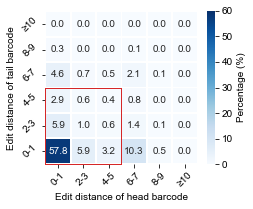

In [10]:
plt.figure(figsize=(3.6, 3))
sns.heatmap(m, annot=True, fmt=".1f", cmap="Blues", lw=0.5, vmin=0, vmax=60,
            square=True, cbar_kws={"label": "Percentage (%)"})
if True:
    plt.plot([0, 3], [3, 3], color="C3", lw=1, clip_on=False)
    plt.plot([0, 3], [6, 6], color="C3", lw=1, clip_on=False)
    plt.plot([0, 0], [3, 6], color="C3", lw=1, clip_on=False)
    plt.plot([3, 3], [3, 6], color="C3", lw=1, clip_on=False)
    
plt.xlabel("Edit distance of head barcode")
plt.ylabel("Edit distance of tail barcode")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/dual_barcode_ed_distribution.pdf", dpi=300)

# Assigned cell reads proportion

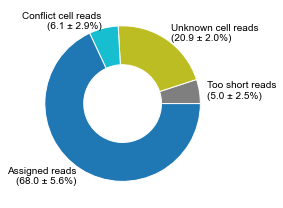

In [4]:
array = []
for run in runs:
    path = "../../1_NanoNASCseq/results/demux/splitted/%s/stats.tsv" % run
    array.append(pd.read_csv(path, sep="\t", index_col=0))
d = pd.concat(array)
columns = ["TooShort", "Unknown", "Conflict", "Assigned"]
d = pd.concat([d[c] * 100 / d["Total"] for c in columns], axis=1)
d.columns = columns
ys = d.mean(axis=0)
stds = d.std(axis=0)

labels = [
    "Too short reads\n(%.1f ± %.1f%%)" % (ys[0], stds[0]),
    "Unknown cell reads\n(%.1f ± %.1f%%)" % (ys[1], stds[1]),
    "Conflict cell reads\n(%.1f ± %.1f%%)" % (ys[2], stds[2]),
    "Assigned reads\n(%.1f ± %.1f%%)" % (ys[3], stds[3])]

plt.figure(figsize=(4, 3))
plt.pie(ys, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'), 
        # autopct='%1.1f%%', 
        # pctdistance=0.72,
        # startangle=0, 
        colors=["C7", "C8", "C9", "C0"], 
        labels=labels)
plt.tight_layout()
plt.savefig("figures/cell_reads_proportion.pdf", dpi=300)